SVM on the Sonar Dataset

In [143]:
import matplotlib.pyplot as plt
## Importing required libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
import pandas as pd
df = pd.read_csv('sonar.csv', header=None)
x_unscaled = df.sample(frac=1, replace=True, random_state=1)
y = x_unscaled[60]
x_unscaled.drop([60],axis=1, inplace=True)
x_unscaled[[10,50]].describe()


,10,50
count,208.000000,208.000000
mean,0.232959,0.017114
std,0.140313,0.013203
min,0.028900,0.001500
25%,0.119125,0.007900
50%,0.230200,0.014450
75%,0.294425,0.021600
max,0.734200,0.100400


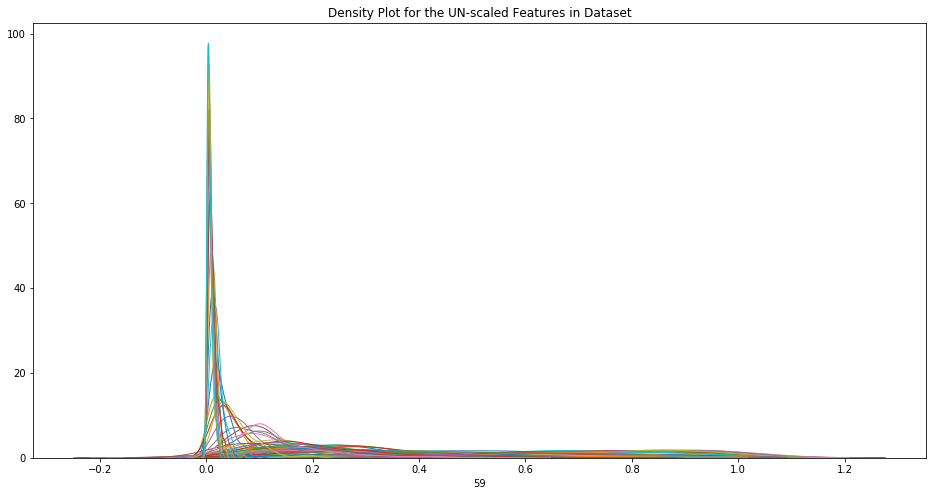

In [122]:

plt.figure(figsize=(16,8))
plt.title('Density Plot for the UN-scaled Features in Dataset')
for i in x_unscaled.columns:
    # Draw the density plot
    sns.distplot(x_unscaled[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1})
    

## Scale the features
The SMV performs faster if features are scaled

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_unscaled)
x = pd.DataFrame(scaler.transform(x_unscaled), index=x_unscaled.index, columns=x_unscaled.columns)
print("x shape: ",x.shape)
x[[10,50]].describe()

x shape:  (208, 60)


,10,50
count,2.080000e+02,2.080000e+02
mean,-2.989062e-17,1.024821e-16
std,1.002413e+00,1.002413e+00
min,-1.457818e+00,-1.185540e+00
25%,-8.132420e-01,-6.996136e-01
50%,-1.971152e-02,-2.022988e-01
75%,4.391181e-01,3.405716e-01
max,3.580913e+00,6.323535e+00


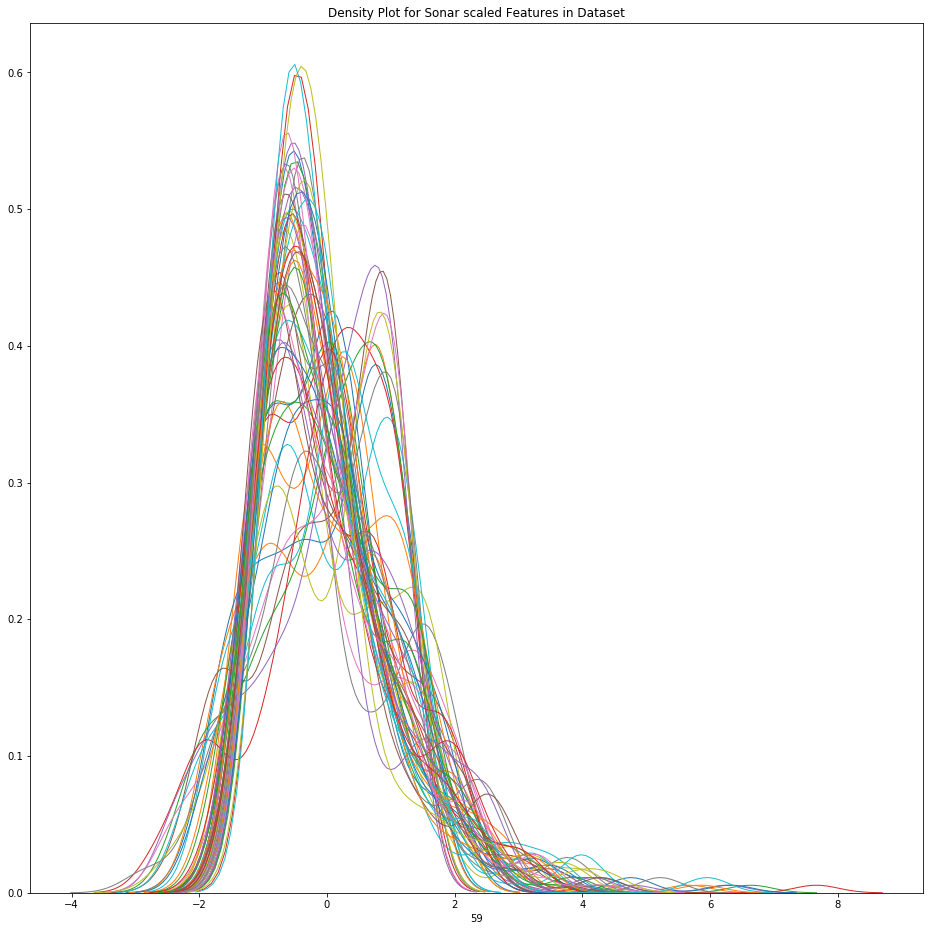

In [145]:
plt.figure(figsize=(16,16))
plt.title('Density Plot for Sonar scaled Features in Dataset')
for i in x.columns:
    # Draw the density plot
    sns.distplot(x[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1})
    

## Fitting a Support Vector Machine
Use Scikit-Learn's support vector classifier to train an SVM model on this data. Let'set the  𝐶  parameter to a very large number.

In [146]:
from sklearn.svm import SVC # "Support vector classifier"
from timeit import default_timer as timer

model = SVC(kernel='linear', C=1E4)
start = timer()
model.fit(x, y)
end = timer()
print(end - start)

model1 = SVC(kernel='linear', C=1E4)
start = timer()
model1.fit(x_unscaled, y)
end = timer()
print(end - start)




0.005107619999762392
0.03811032199973852


In [147]:
print(len(model.support_vectors_))
#print(model.support_vectors_)

print(len(model1.support_vectors_))
#print(model1.support_vectors_)

52
60


The SVM fit performed on unscalsed features is 6 times slower and has 8 more support vectors 

From the previous experiences with the Sonar Dataset (https://github.com/borodark/ie7860/blob/master/Feature%20Selection%20and%20Visualization%20Sonar%20Data%20Set.ipynb) we know that several features are more important. Here is 24 best Features by F score: [0  1  3  7  8  9 10 11 12 33 35 36 43 44 45 46 47 48 49 50 51 53 57 59]

Let's fit SVM on 2 and visualize the hyperplane

## Fit SVM on 2 features and visualize the hyperplane

In [148]:
# define the function for plotting the decision boundary
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1, color='#000000', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [149]:
# fit SVM on features [10,50] - 
X = x[[10,50]]
X1 = X.to_numpy()


In [150]:
model3 = SVC(kernel='linear', C=1E4)
start = timer()
model3.fit(X, y)
end = timer()
print(end - start)


0.2013787650002996


There are  99  support vectors 


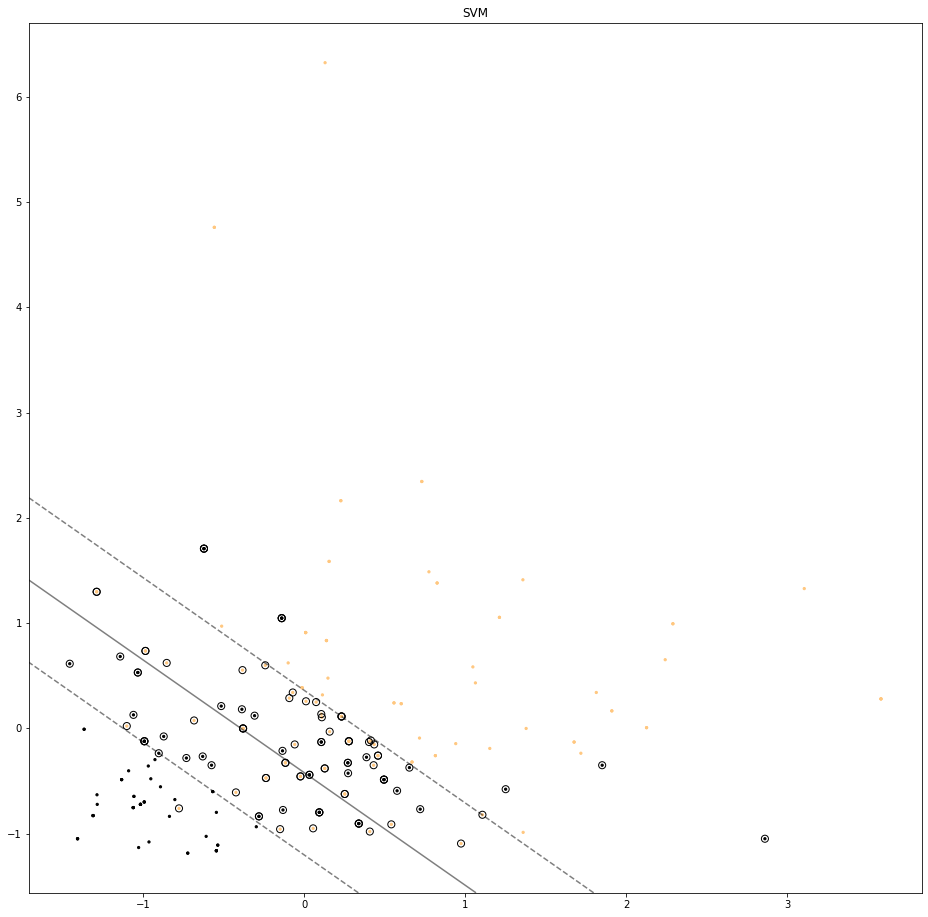

In [151]:
print("There are ", len(model3.support_vectors_), " support vectors ")
plt.figure(figsize=(16,16))
plt.title('SVM')
plt.scatter(X1[:, 0], X1[:, 1], c=y, s=5, cmap='copper')
plot_svc_decision_function(model3);

## Use 'poly' kernel with SVM

In [152]:
poly = SVC(kernel='poly', C=1E4, gamma='scale')
poly.fit(X, y)


SVC(C=10000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

There are  97  support vectors for poly kernel


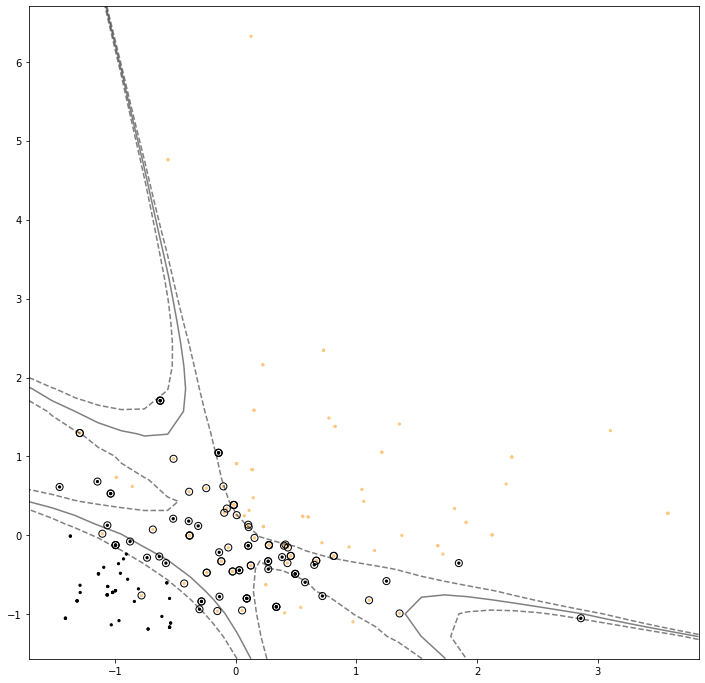

In [156]:
print("There are ", len(poly.support_vectors_), " support vectors for poly kernel")
plt.figure(figsize=(12,12))
plt.scatter(X1[:, 0], X1[:, 1], c=y, s=5, cmap='copper')
plot_svc_decision_function(poly);

## Comparing to other Classifiers

### Scaled features dataset

In [157]:
# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


In [158]:
# Create a validation dataset
# Split-out validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=1)
X_train[[10,50]].head()

,10,50
23,-1.135619,-0.487021
97,-0.987737,0.735386
94,-0.954159,-0.479428
47,-0.546946,-0.798317
10,-1.312793,-0.828688


In [159]:
X_test[[10,50]].head()

,10,50
24,-1.368517,-0.008688
54,-0.631961,-0.266836
114,0.111740,0.317794
205,0.276054,-0.122577
115,-0.014711,0.386127


In [160]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.850368 (0.069524)
LDA: 0.758824 (0.079809)
KNN: 0.880147 (0.108518)
CART: 0.836397 (0.086663)
NB: 0.747426 (0.057335)
SVM: 0.904779 (0.053212)


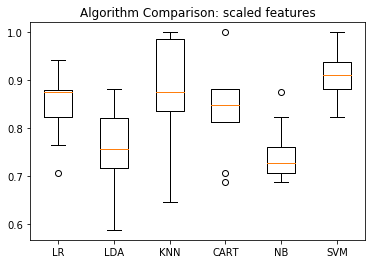

In [161]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison: scaled features')
plt.show()

SVM has the highest median out of all!

In [162]:
# Make predictions on validation dataset
model = SVC(gamma='auto',C=1E10)
start = timer()
model.fit(X_train, Y_train)
end = timer()
print(end - start)
predictions = model.predict(X_test)

0.003969833999690309


There are  91  support vectors 
0.9761904761904762
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.98        21

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42

Confusion Matrix:


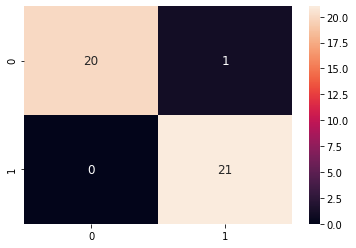

In [163]:
# Evaluate predictions
print("There are ", len(model.support_vectors_), " support vectors ")
print(accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test,predictions)
print('Confusion Matrix:')
sns.heatmap(cm,annot=True,fmt="d", annot_kws={"size": 12}) # font size

### Unscaled features

In [164]:
# Create a validation dataset
# Split-out validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(x_unscaled, y, test_size=0.20, random_state=1)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.785294 (0.114080)
LDA: 0.758824 (0.079809)
KNN: 0.819485 (0.088426)
CART: 0.824265 (0.065639)
NB: 0.747426 (0.057335)
SVM: 0.631985 (0.066043)


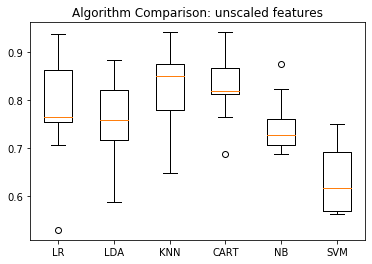

In [165]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison: unscaled features')
plt.show()

### Conclusion
* The SVM classifier is able to reach %98 accuracy and performs faster then MLP - fit takes only `0.003992759000539081` seconds compare to several minutes for Neural Networks 
* The SVM classifier is sensitive to feature sclaing: slower speed and lower precision